## Földunarnet

In [3]:
# Load data

import numpy as np
import tensorflow as tf

def readData(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

np.random.seed(100)
trainData, trainLabels = readData("C:\\Users\\snati\\Documents\\Eðlisfræði\\3 ár\\Gervigreind-vor-2019\\Homework 9\\images_train.csv",
                                  'C:\\Users\\snati\\Documents\\Eðlisfræði\\3 ár\\Gervigreind-vor-2019\\Homework 9\\labels_train.csv')
p = np.random.permutation(60000)
trainData = trainData[p,:]

# One-hot encoding of class labels
trainLabels = tf.keras.utils.to_categorical(trainLabels, num_classes=10)
trainLabels = trainLabels[p,:]

# Take 10000 training samples aside for validation (a.k.a. "dev" set)
devData = trainData[0:10000,:]
devLabels = trainLabels[0:10000,:]
trainData = trainData[10000:,:]
trainLabels = trainLabels[10000:,:]

# Remove mean from data and scale it to speed up training
mean = np.mean(trainData)
std = np.std(trainData) # a scalar value
trainData = (trainData - mean) / std
devData = (devData - mean) / std

testData, testLabels = readData('C:\\Users\\snati\\Documents\\Eðlisfræði\\3 ár\\Gervigreind-vor-2019\\Homework 9\\images_test.csv',
                                'C:\\Users\\snati\\Documents\\Eðlisfræði\\3 ár\\Gervigreind-vor-2019\\Homework 9\\labels_test.csv')
testLabels = tf.keras.utils.to_categorical(testLabels, num_classes=10)
testData = (testData - mean) / std

# Convert data to 32-bit floating point representation
# This saves memory and speeds up training of deep networks
# and is *essential* for utilizing GPUs for training.
trainData = trainData.astype('float32')
testData = testData.astype('float32')

In [4]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Dense#, Activation
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import Adadelta

num_epochs = 2 # Increase to get improved accuracy
batch_size = 128

img_rows, img_cols = 28, 28 # input image dimensions
num_classes = 10

x_train = trainData.reshape(trainData.shape[0], img_rows, img_cols, 1)
y_train = trainLabels

x_val = devData.reshape(devData.shape[0], img_rows, img_cols, 1)
y_val = devLabels

x_test = testData.reshape(testData.shape[0], img_rows, img_cols, 1)
y_test = testLabels
input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

history=model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=(x_val, y_val))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (50000, 28, 28, 1)
50000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
den

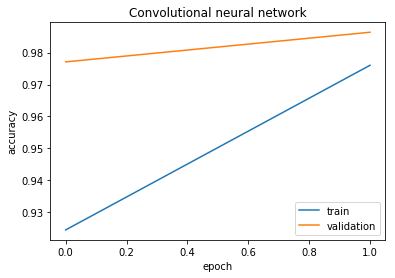

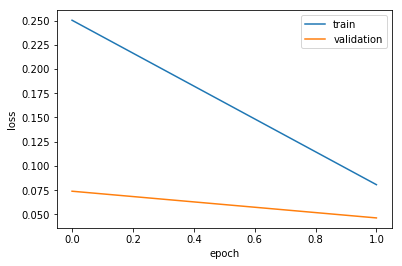

In [6]:
# Visualize training history
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Convolutional neural network')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## Endurkvæm net

Sýnidæmið hér að neðan er dæmi um "sequence to sequence" lærdóm með endurkvæmu tauganeti. Netið lærir samlagningu tveggja talna. Inntak er strengur á borð við "123+45" og úttakið "168". Netið er þjálfað á nokkur þúsund dæmum sem útbúin eru af handahófi. Netið er síðan prófað á dæmum sem það hefur ekki séð áður.

In [7]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import layers
import numpy as np


class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.

        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.

        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.

        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

    # Evaluate performance on the validation set
    #corr=0
    #for ind in range(len(x_val)):
    #    rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
    #    preds = model.predict_classes(rowx, verbose=0)
    #    q = ctable.decode(rowx[0])
    #    correct = ctable.decode(rowy[0])
    #    guess = ctable.decode(preds[0], calc_argmax=False)
    #    if correct == guess:
    #        corr+=1
    #print("Validation accuracy:", corr/len(x_val))   

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________

--------------------------------------------------
Iteration 1
Train on 45000 samples, validat

KeyboardInterrupt: 